<a href="https://colab.research.google.com/github/adwod/proyect_buyer/blob/main/Copia_de_Taller_Modelizaci%C3%B3n_Supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

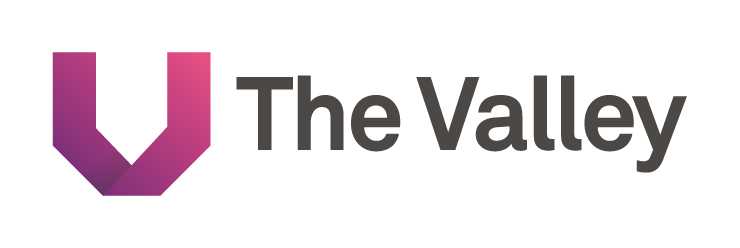</img>

# Workshop de modelización: Modelos Supervisados

Una empresa de inversión en activos inmobiliarios, busca la creación de un algoritmo que estime el precio de una vivienda. El objetivo de este sistema es doble:

1. Poder tasar casas de manera automática
2. Poder encontrar activos que estén bien de precio

Para ello os unís al uniros al equipo de Data Science de un fondo de inversión y os detallan los diferentes pasos para aproximar el problema: 



### 1) Exploratory Data Analysis

1.   Comprobar que el Dataset está balanceado
2.   Visualizaciones del conjunto de datos con la librería seaborn
3.   Detección de outliers

### 2) Feature Engineering (Ingeniería de variables)

1. Manipulación de las variables existentes
2. Creación de nuevas variables para el modelo 
3. (Extra) utilización de técnicas no supervisadas como PCA para crear nuevas variables
4. (Extra) Utilización de target encoding 
5. (Extra) ¿Qué datos externos utilizarías?

### 3) Modelado

1. Utilización de diferentes modelos dados en clase: k-nn, Random Forest, Regresión Lineal, XGBoost
2. Elección de una métrica de evaluación
3. Split entre train y test de los datos
4. Split estratificado por `LOCATIONNAME`


### 4) Overfitting (Extra)

1. RMSE más bajo que puede obtener para el conjunto de entrenamiento (MAL ENTRENADO)
2. Evalua gráficamente tu overfitting
3. (Extra) Analiza la descomposición entre sesgo y varianza

### 5) Evaluación de predicciones

1. Evalua el rendimiento de los diferentes modelos
2. Dadas las predicciones de tus modelos, explorar donde funciona mejor y peor
3. Selecciona un modelo
4. Conclusiones
5. (Extra) Interpreta las predicciones con la libreria `shap`

### 6) Encontrar Chollos (Extra)

1. ¿Cómo orientarías la búsqueda de chollos en el dataset?
2. ¿Cómo varía la modelización al buscar oportunidades inmobiliarias?

### 7) Explicar el caso en 3 slides (Opcional y corrección por email)

 * The major insights you extracted
 * A brief explanation of your solution
 * Impact of your solution
 * (Optional) An extra slide on how you would put the model into production




### 0) Cargamos nuestra base de datos

 - `CODE`, código de la referencia
 - `LOCATIONNAME`, nombre de la localización
 - `PRICE`, precio de venta en €
 - `AREA`, metros cuadrados ($m^2$)
 - `ROOMNUMBER`, número de habitaciones
 - `BATHNUMBER`, número de baños
 - `STATUS`, estado del piso
 - `STUDIO`, es un estudio
 - `ISPENTHOUSE`, es una casa
 - `DUPLEX`, es un duplex
 - `SWIMMINGPOOL`, tiene piscina
 - `ELEVATOR`, tiene ascensor
 - `X` Longitud en UTM
 - `Y` Latitud en UTM



In [ ]:
!pip install h2o
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import kstest
from sklearn.metrics import r2_score
import pandas.util.testing as tm
import h2o
from sklearn.cluster import DBSCAN
import statsmodels.api as sm
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

#import warnings
#warnings.filterwarnings('ignore')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.1 MB 47 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.4-py2.py3-none-any.whl size=177128127 sha256=d0ffe28a2bd8bbcb5afcffc59d503f95aec20565b38b207d950c3014a8f5925f
  Stored in directory: /root/.cache/pip/wheels/02/f9/18/5fbae4db903beda26f764b6e035cb41b37713fed8a6b9cd403
Successfully built h2o


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
df_flats = pd.read_csv('https://github.com/pelayoarbues/the_valley_public_data/blob/master/sample-flats-madrid-synthetic-coords-pelayo.csv?raw=true', delimiter=',')
df_flats.head()

,CODE,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STATUS,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y
0,6606863734075793541,El Viso,1869000,290,4,3,Second hand / Good state,0,1,1,0,1,441543,4478087
1,9223372036854775807,Adelfas,317000,75,2,1,Second hand / Good state,0,0,0,0,1,442956,4472317
2,9223372036854775807,Rosas,292000,90,2,2,Second hand / Good state,0,0,0,1,1,448837,4475183
3,6074027706670131934,Palomeras Bajas,95000,75,3,1,Second hand / Good state,0,0,0,0,0,444520,4470756
4,9223372036854775807,San Diego,86000,90,0,1,Second hand / Needs reformation,0,0,0,0,0,443178,4470744


In [ ]:
dummy_columns = {
    'STATUS': {
        'prefix': 'STAT',
        'sep': ";"
    }
}

for column_name, dummy_data in dummy_columns.items():
	# Recogemos un DataFrame con una columna dummy por cada valor
    dummies = df_flats[column_name].str.get_dummies(sep=dummy_data['sep'])

    # Añadimos `prefix` a cada columna
    dummies.columns = map(lambda col: f'{dummy_data["prefix"]}_{col}', dummies.columns)
    
    # Añadimos las columnas dummy al df original
    df_flats = pd.concat([df_flats, dummies], axis=1)

# [Opcional] Eliminamos las columnas originales de df
df_flats = df_flats.drop(columns=dummy_columns.keys())

#df_flats_dumm Ahora df.head() mostrará las columnas dummy


In [ ]:

df_flats=df_flats.drop(["CODE"],axis=1)
df_flats.head()

,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown
0,El Viso,1869000,290,4,3,0,1,1,0,1,441543,4478087,0,1,0,0
1,Adelfas,317000,75,2,1,0,0,0,0,1,442956,4472317,0,1,0,0
2,Rosas,292000,90,2,2,0,0,0,1,1,448837,4475183,0,1,0,0
3,Palomeras Bajas,95000,75,3,1,0,0,0,0,0,444520,4470756,0,1,0,0
4,San Diego,86000,90,0,1,0,0,0,0,0,443178,4470744,0,0,1,0


In [ ]:
filtro_precio_bajo= df_flats["PRICE"]<1000
df_flats_precio_bajo= df_flats[filtro_precio_bajo]
df_flats.drop(df_flats[filtro_precio_bajo].index)

,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown
0,El Viso,1869000,290,4,3,0,1,1,0,1,441543,4478087,0,1,0,0
1,Adelfas,317000,75,2,1,0,0,0,0,1,442956,4472317,0,1,0,0
2,Rosas,292000,90,2,2,0,0,0,1,1,448837,4475183,0,1,0,0
3,Palomeras Bajas,95000,75,3,1,0,0,0,0,0,444520,4470756,0,1,0,0
4,San Diego,86000,90,0,1,0,0,0,0,0,443178,4470744,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26750,Goya,551000,170,5,2,0,0,0,0,1,443102,4475175,0,1,0,0
26751,Trafalgar,577000,155,5,2,0,0,0,0,1,440737,4476236,0,0,1,0
26752,Ventilla-Almenara,304000,130,3,2,0,0,0,0,1,441152,4480360,0,0,1,0
26753,Castellana,1001000,155,4,2,0,0,0,0,1,442184,4475840,0,1,0,0


In [ ]:
df_flats["PRICE_M2"]= df_flats["PRICE"]/df_flats["AREA"]



In [ ]:
df_flats.sort_values(by=["PRICE_M2"])

,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown,PRICE_M2
17909,Ambroz,0,130,2,2,0,0,0,0,0,448464,4473186,0,0,1,0,0.000000e+00
14544,Pacífico,0,90,2,1,0,0,0,0,1,442566,4473120,0,0,1,0,0.000000e+00
13636,Sanchinarro,1000,100,2,2,0,0,0,1,1,444313,4483153,0,1,0,0,1.000000e+01
3440,Cuzco-Castillejos,1000,60,1,1,0,0,0,1,1,441036,4478806,0,1,0,0,1.666667e+01
21315,Butarque,1000,55,2,1,0,0,0,0,0,442028,4467275,0,1,0,0,1.818182e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9408,Guindalera,6005000,50,2,1,0,0,0,0,1,443143,4476096,0,1,0,0,1.201000e+05
21373,Jerónimos,17802000,130,3,2,0,1,0,0,1,441440,4474536,0,1,0,0,1.369385e+05
3483,Gaztambide,24117000,100,3,2,0,0,0,0,1,439429,4476368,0,1,0,0,2.411700e+05
25684,Almagro,48160000,105,2,2,0,0,0,1,1,440661,4476611,0,1,0,0,4.586667e+05


In [ ]:
df_flats["PRICE_M2"]=np.round(df_flats['PRICE_M2'], 
                       decimals = 2)  

In [ ]:
df_flats.head(20)

,LOCATIONNAME,PRICE,AREA,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,X,Y,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown,PRICE_M2
0,El Viso,1869000,290,4,3,0,1,1,0,1,441543,4478087,0,1,0,0,6444.83
1,Adelfas,317000,75,2,1,0,0,0,0,1,442956,4472317,0,1,0,0,4226.67
2,Rosas,292000,90,2,2,0,0,0,1,1,448837,4475183,0,1,0,0,3244.44
3,Palomeras Bajas,95000,75,3,1,0,0,0,0,0,444520,4470756,0,1,0,0,1266.67
4,San Diego,86000,90,0,1,0,0,0,0,0,443178,4470744,0,0,1,0,955.56
5,Casa de Campo,410000,105,3,2,0,0,0,0,1,437560,4475863,0,0,1,0,3904.76
6,Lavapiés-Embajadores,235000,50,1,1,0,0,0,0,0,440205,4473206,0,1,0,0,4700.00
7,Tres Olivos - Valverde,135000,85,3,1,0,0,0,0,0,441356,4482735,0,0,1,0,1588.24
8,Águilas,157000,90,3,1,0,0,0,0,1,433736,4470235,0,0,1,0,1744.44
9,Almendrales,87000,45,1,1,0,0,0,0,0,440380,4470765,0,1,0,0,1933.33


In [ ]:
df_flats_final=df_flats.drop(["PRICE","AREA","X","Y"],axis=1)

In [ ]:
df_flats_final=df_flats_final.sort_values(by=["PRICE_M2"])

In [ ]:
df_flats_final.head()

,LOCATIONNAME,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown,PRICE_M2
17909,Ambroz,2,2,0,0,0,0,0,0,0,1,0,0.00
14544,Pacífico,2,1,0,0,0,0,1,0,0,1,0,0.00
13636,Sanchinarro,2,2,0,0,0,1,1,0,1,0,0,10.00
3440,Cuzco-Castillejos,1,1,0,0,0,1,1,0,1,0,0,16.67
21315,Butarque,2,1,0,0,0,0,0,0,1,0,0,18.18


In [ ]:
filtro_precio_cero= df_flats_final["PRICE_M2"]<100
df_flats_precio_cero= df_flats_final[filtro_precio_cero]
df_flats_final=df_flats_final.drop(df_flats_final[filtro_precio_bajo].index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_flats_final.columns

Index(['LOCATIONNAME', 'ROOMNUMBER', 'BATHNUMBER', 'STUDIO', 'ISPENTHOUSE',
       'DUPLEX', 'SWIMMINGPOOL', 'ELEVATOR', 'STAT_New development',
       'STAT_Second hand / Good state', 'STAT_Second hand / Needs reformation',
       'STAT_Second hand / Unknown', 'PRICE_M2'],
      dtype='object')

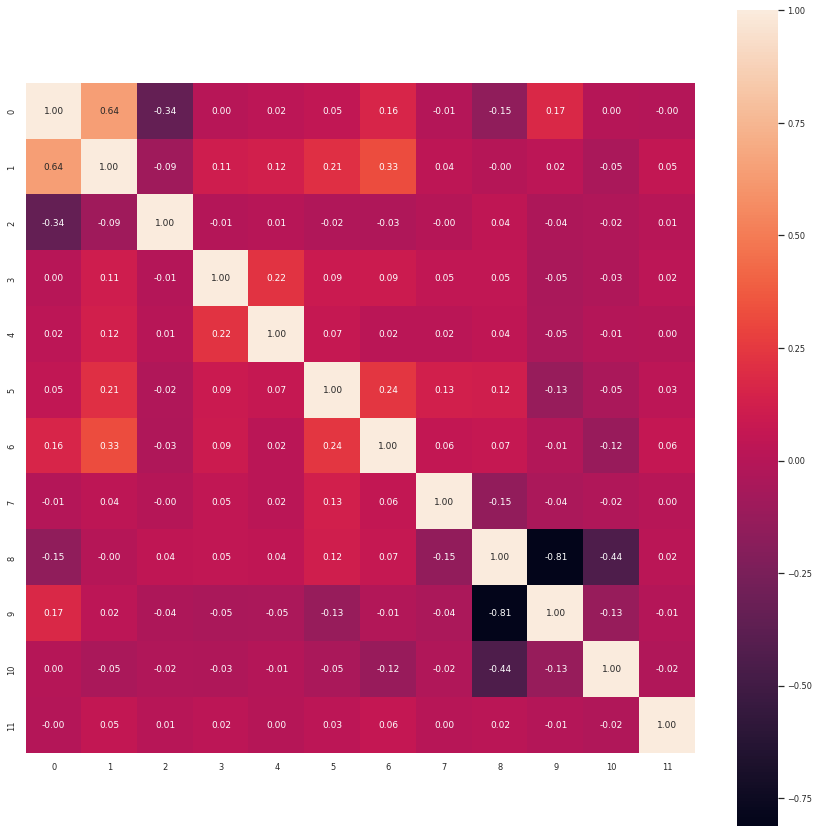

In [ ]:

plt.figure(figsize=(15,15))
cols=[ 'ROOMNUMBER', 'BATHNUMBER', 'STUDIO', 'ISPENTHOUSE',
       'DUPLEX', 'SWIMMINGPOOL', 'ELEVATOR', 'STAT_New development',
       'STAT_Second hand / Good state', 'STAT_Second hand / Needs reformation',
       'STAT_Second hand / Unknown', 'PRICE_M2']
cm= np.corrcoef(df_flats_final[cols].values.T)
sns.set(font_scale=0.75)
hm=sns.heatmap(cm,cbar=True,annot=True,square=True, fmt=".2f")
annot_kws=()

plt.show()

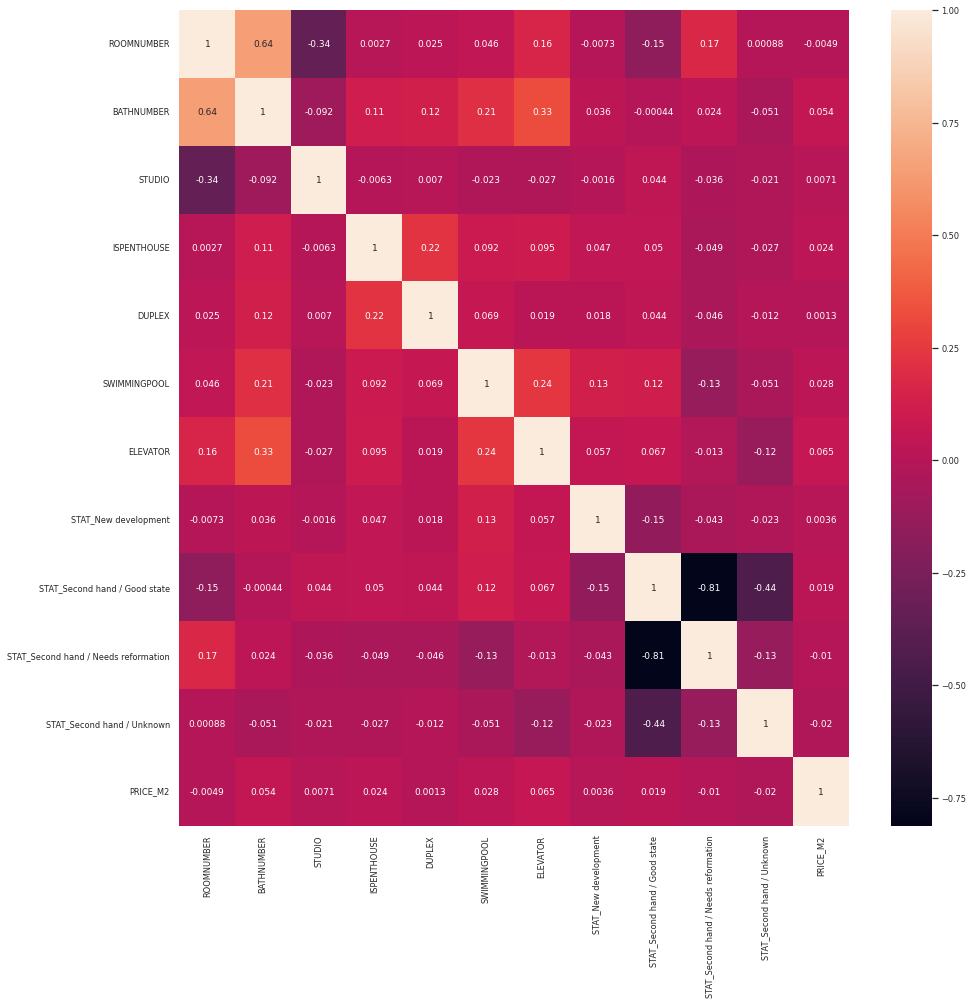

In [ ]:
corr_df = df_flats_final.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
df_flats_final[(df_flats["SWIMMINGPOOL"]==1) & (df_flats_final["PRICE_M2"]>800)]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,LOCATIONNAME,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown,PRICE_M2
6768,Huertas-Cortes,3,2,0,0,0,1,1,0,0,0,1,905.88
18144,Valdebebas - Valdefuentes,2,2,0,0,0,1,1,0,1,0,0,988.89
1764,Fuente del Berro,3,1,0,0,0,1,1,0,1,0,0,1000.00
24740,San Fermín,3,2,0,0,0,1,1,0,1,0,0,1174.36
19066,San Andrés,4,1,0,0,0,1,0,0,1,0,0,1191.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,Argüelles,3,3,0,1,0,1,1,1,0,0,0,13471.43
2188,Lista,2,2,0,0,0,1,1,0,1,0,0,14055.17
15681,Almagro,2,2,0,1,0,1,1,0,1,0,0,14883.33
25684,Almagro,2,2,0,0,0,1,1,0,1,0,0,458666.67


In [ ]:
filtro_precio_outliers= df_flats_final["PRICE_M2"]>20000
df_flats_precio_outliers= df_flats_final[filtro_precio_outliers]
df_flats_final=df_flats_final.drop(df_flats_final[filtro_precio_outliers].index)

In [ ]:
filtro_precio_outliers_bajos=df_flats_final["PRICE_M2"]<100
df_flats_precio_outliers_bajos= df_flats_final[filtro_precio_outliers_bajos]
df_flats_final=df_flats_final.drop(df_flats_final[filtro_precio_outliers_bajos].index)

In [ ]:
df_flats_final["BATH&ELEVATOR"]= df_flats_final["BATHNUMBER"]* df_flats_final["ELEVATOR"]

In [ ]:
df_flats_final.head()

,LOCATIONNAME,ROOMNUMBER,BATHNUMBER,STUDIO,ISPENTHOUSE,DUPLEX,SWIMMINGPOOL,ELEVATOR,STAT_New development,STAT_Second hand / Good state,STAT_Second hand / Needs reformation,STAT_Second hand / Unknown,PRICE_M2,BATH&ELEVATOR
6585,Pacífico,2,1,0,0,0,0,1,0,0,1,0,101.57,1
19758,Amposta,3,1,0,0,0,0,0,0,0,0,1,200.00,0
6401,Niño Jesús,4,3,0,0,0,1,1,0,1,0,0,206.67,3
14288,Cuatro Caminos,3,1,0,0,0,0,0,0,1,0,0,247.06,0
15942,San Cristóbal,4,1,0,0,0,0,0,0,1,0,0,280.00,0


In [ ]:
def fuera_std(s, nstd=3.0, return_thresholds=False):
    """
    Definir una funcion que devuelva si el punto de la variable se 
    encuentra dentro o fuera de la franja de desviaci'on estandar 
    de la distribuci'on de la variables.
    Si return_thresholds es True se le pedirá que nos mande los 
    umbrales en los que está haciendo el corte
    """
    data_media, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    limite_inferior, limite_superior = data_media - cut_off, data_media + cut_off
    if return_thresholds:
        return limite_inferior, limite_superior
    else:
        return [True if x < limite_inferior or x > limite_superior else False for x in s]


In [ ]:
outliers_std = fuera_std(df_flats_final["PRICE_M2"],3,False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


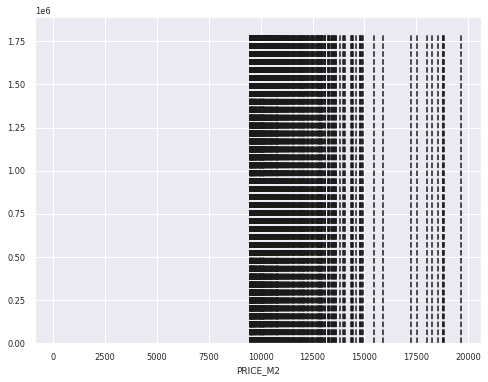

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(df_flats_final["PRICE_M2"], kde=False);
plt.vlines(df_flats_final["PRICE_M2"][outliers_std], 
           ymin=0, ymax=1800000, 
           linestyles='dashed');

In [ ]:
def fuera_iqr(s, 
              k=1.5, 
              return_thresholds=False):
    """Calcula el IQR y lo multiplica por un k que define el 
   limite final para detectar outliers.
    Si return_thresholds es True se le pedirá que nos mande los 
    umbrales en los que está haciendo el corte.
   
    """
    # calcular IQR
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calcular el corte de los outliers
    cut_off = iqr * k
    limite_inferior, limite_superior = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return limite_inferior, limite_superior
    else: 
        return [True if x < limite_inferior or x > limite_superior else False for x in s]

In [ ]:
outliers_iqr = fuera_iqr(df_flats_final["PRICE_M2"],1.5,False)

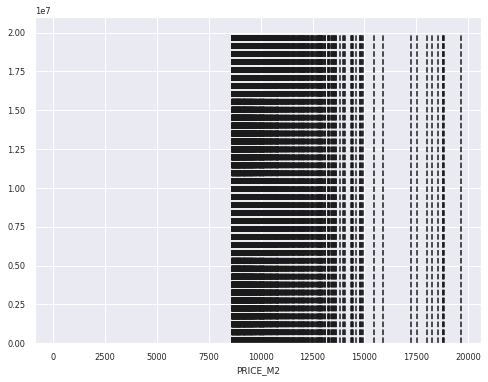

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(df_flats_final["PRICE_M2"], kde=False);
plt.vlines(df_flats_final["PRICE_M2"][outliers_iqr], 
           ymin=0, ymax=20000000, 
           linestyles='dashed');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd459eb1b50>,
      dtype=object)

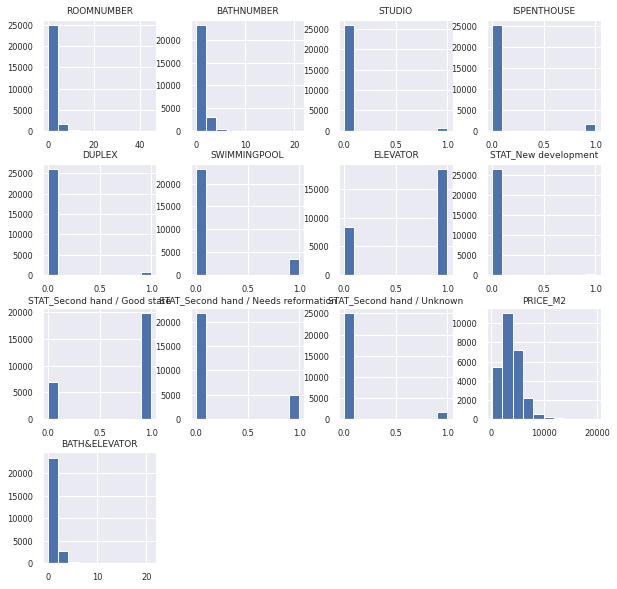

In [ ]:
df_flats_final.hist(figsize=(10,10))


In [ ]:
df_price_median=df_flats_final.pivot_table(values="PRICE_M2",index="LOCATIONNAME",aggfunc=np.median)

df_price_median

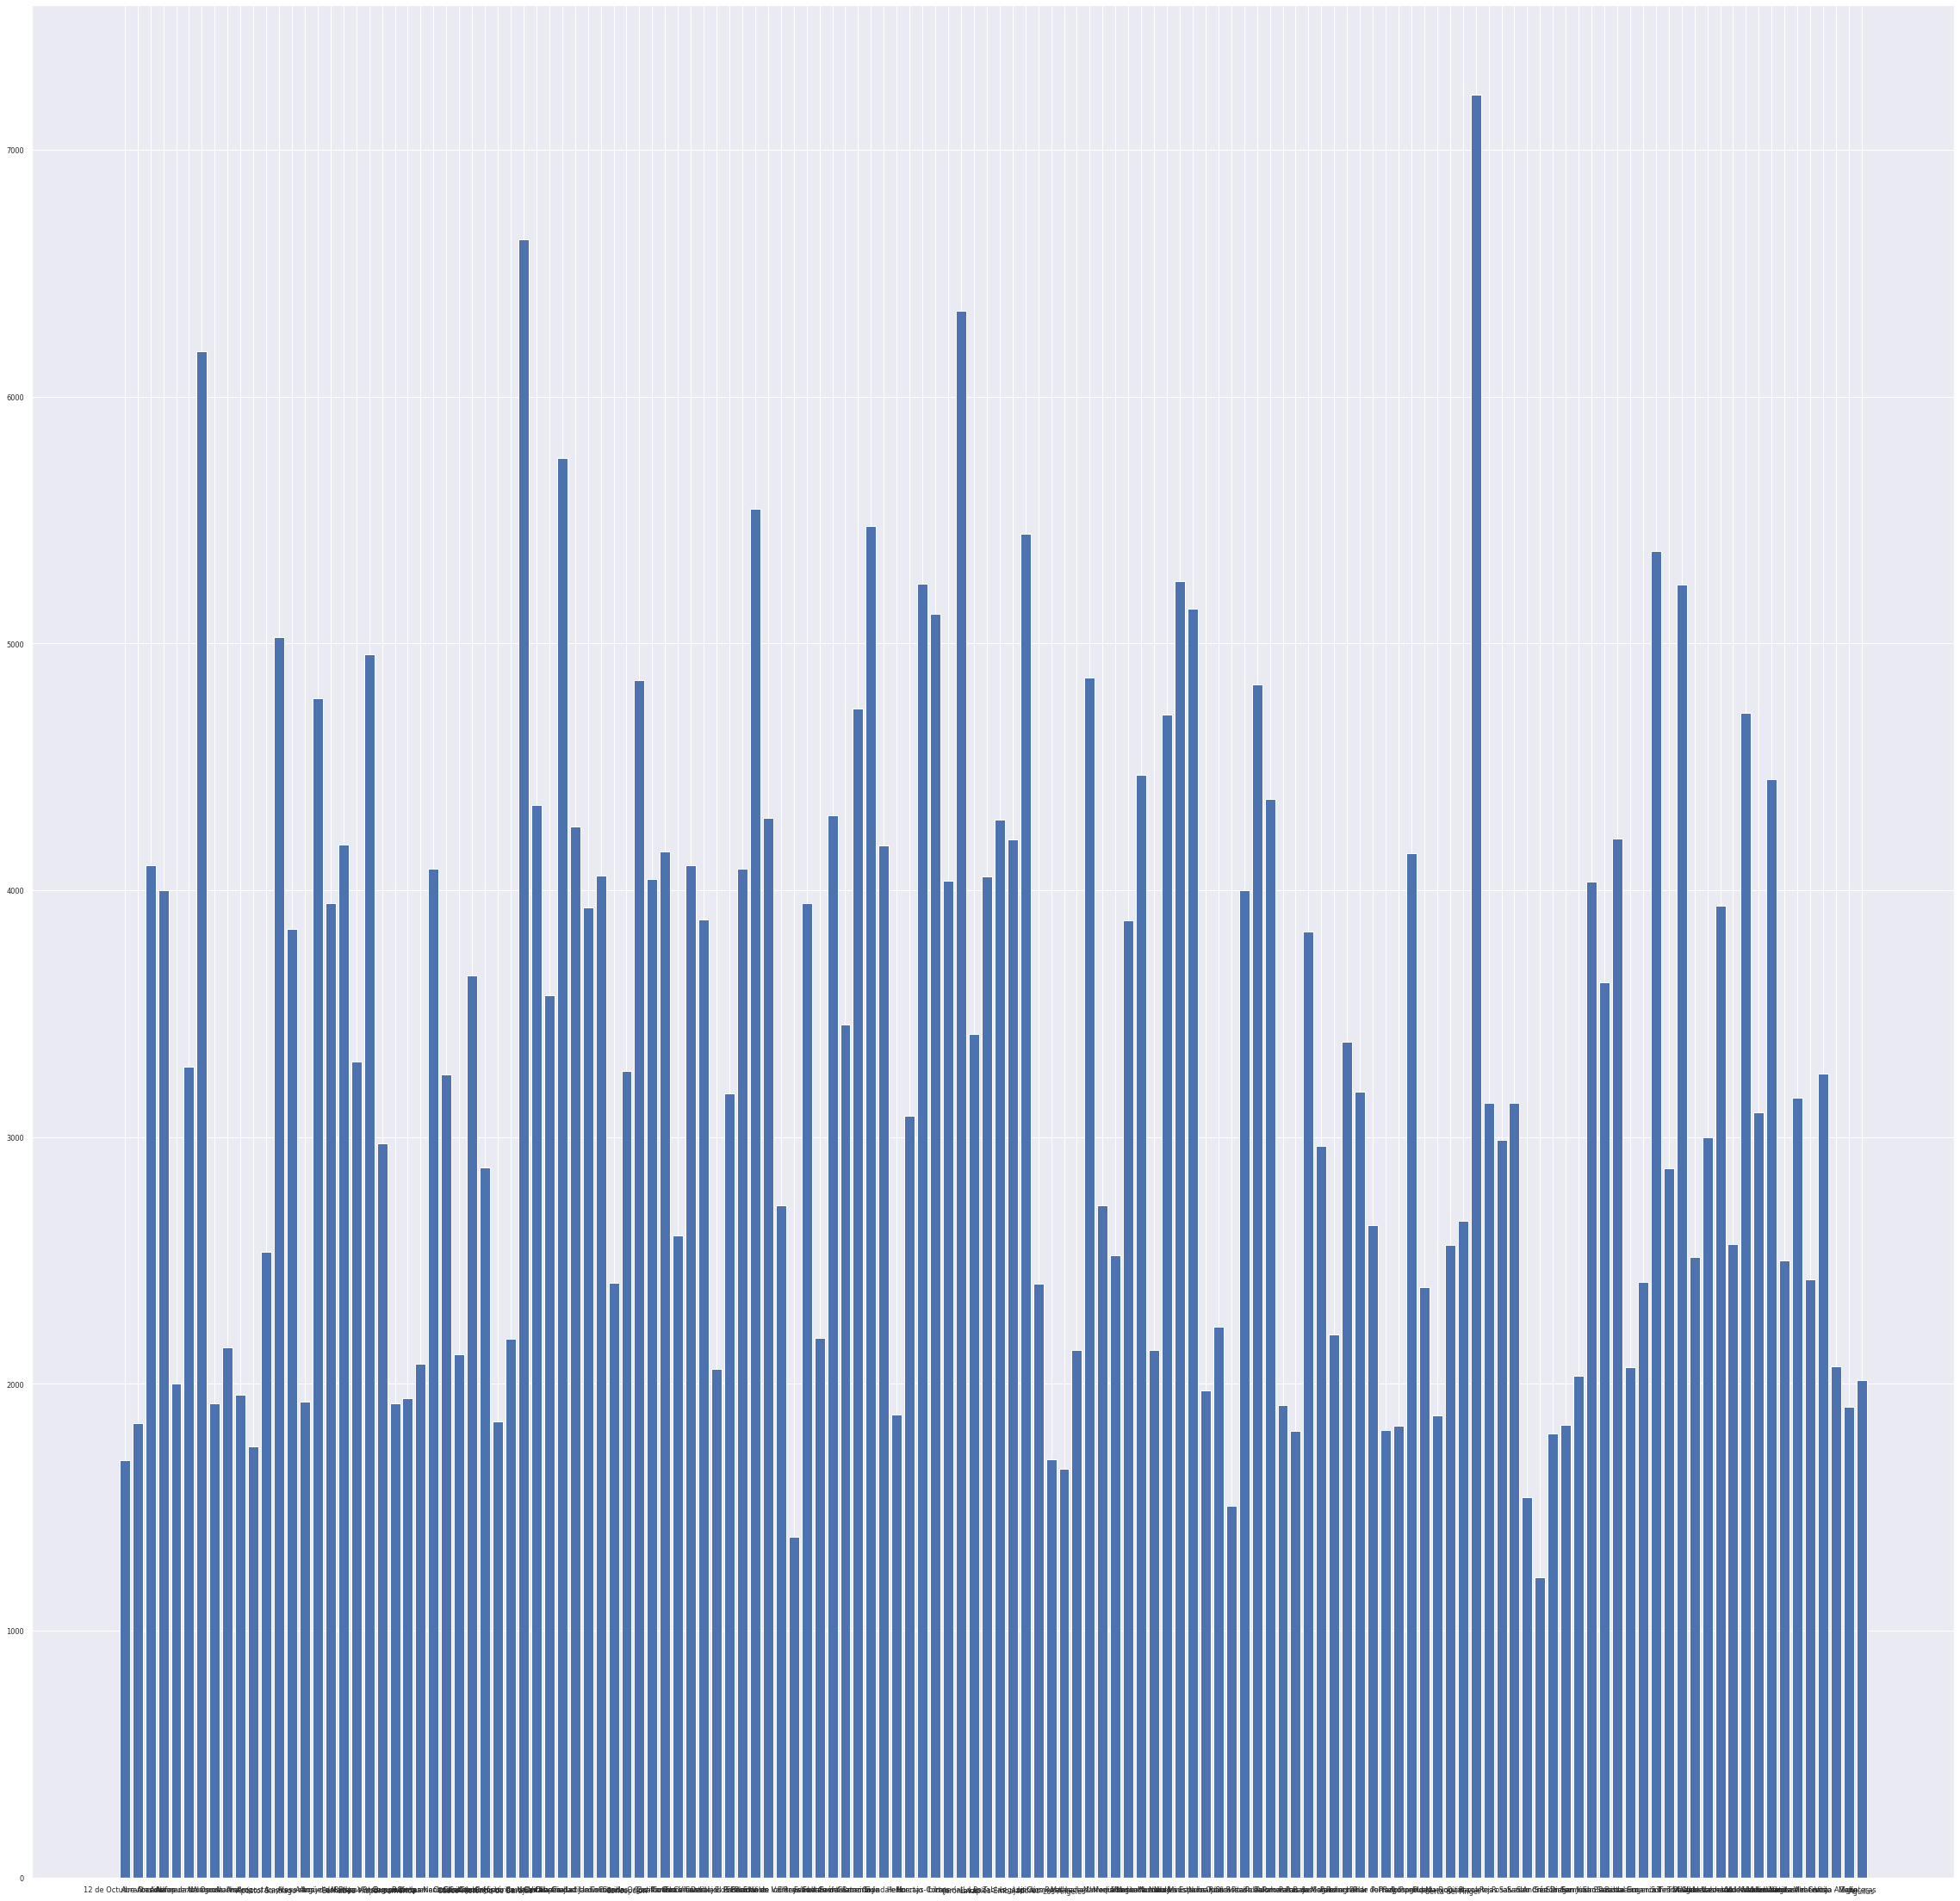

In [ ]:
plt.figure(figsize=(40,40))
plt.bar(df_price_median.index,df_price_median["PRICE_M2"])
plt.show()

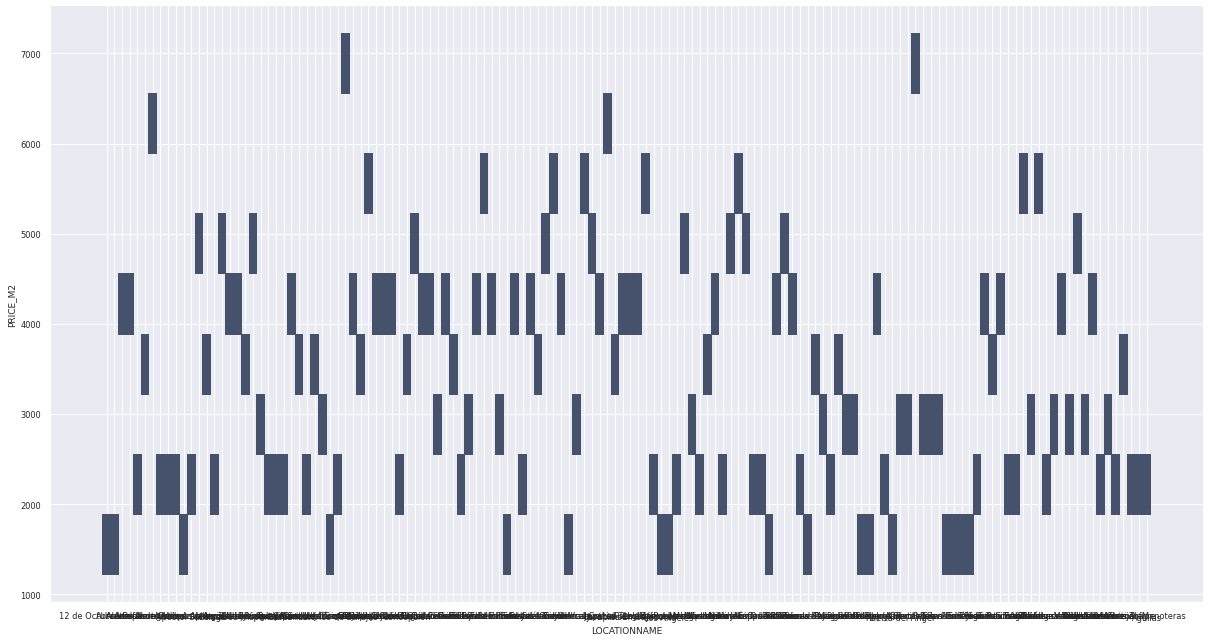

In [ ]:

p=sns.displot(df_price_median,x="LOCATIONNAME",y="PRICE_M2",height=9, aspect=15/8)

In [ ]:


#df_flats_dumm Ahora df.head() mostrará las columnas dummy
dummy_columns = {
    'LOCATIONNAME': {
        'prefix': 'LOC',
        'sep': ";"
    }
}

for column_name, dummy_data in dummy_columns.items():
	# Recogemos un DataFrame con una columna dummy por cada valor
    dummies = df_flats_final[column_name].str.get_dummies(sep=dummy_data['sep'])

    # Añadimos `prefix` a cada columna
    dummies.columns = map(lambda col: f'{dummy_data["prefix"]}_{col}', dummies.columns)
    
    # Añadimos las columnas dummy al df original
    df_flats_final = pd.concat([df_flats_final, dummies], axis=1)

# [Opcional] Eliminamos las columnas originales de df
df_flats_final = df_flats_final.drop(columns=dummy_columns.keys())

In [ ]:
X=df_flats_final.drop(["PRICE_M2"],axis=1)
y=df_flats_final["PRICE_M2"]


X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=123)

In [ ]:
X.shape

(26729, 148)

In [ ]:
sc=StandardScaler()
X_train_scaled= sc.fit_transform(X_train)
X_test_scaled= sc.transform(X_test)

In [ ]:
pca=PCA()
X_train=pca.fit_transform(X_train)
X_test= pca.transform(X_test)


In [ ]:
print("shape of X_train", X_train.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))

shape of X_train (18710, 148)
[5.33903125e-01 1.51897492e-01 5.14871623e-02 3.95567681e-02
 1.80378603e-02 1.42994387e-02 9.70696673e-03 5.02036630e-03
 4.77496960e-03 4.19043052e-03 3.84871233e-03 3.64940809e-03
 3.42194742e-03 3.25792242e-03 2.97046501e-03 2.83248784e-03
 2.80270978e-03 2.72961692e-03 2.67409902e-03 2.65129117e-03
 2.59681910e-03 2.45779456e-03 2.39024555e-03 2.30642283e-03
 2.29449582e-03 2.21428359e-03 2.13059773e-03 2.10788927e-03
 2.09549263e-03 2.06478067e-03 2.05784691e-03 2.04840917e-03
 2.02215386e-03 1.99825586e-03 1.99111240e-03 1.95512226e-03
 1.93179574e-03 1.91341267e-03 1.88302685e-03 1.87203473e-03
 1.84123437e-03 1.82041477e-03 1.77206392e-03 1.75555002e-03
 1.73602990e-03 1.70293030e-03 1.67978267e-03 1.64430512e-03
 1.62400911e-03 1.59631784e-03 1.57351752e-03 1.52245768e-03
 1.49691552e-03 1.49272244e-03 1.45149206e-03 1.43610963e-03
 1.42134094e-03 1.41056163e-03 1.38311538e-03 1.37183139e-03
 1.36663795e-03 1.35524280e-03 1.34458387e-03 1.3313117

In [ ]:
model= LinearRegression()
model.fit(X_train,y_train)
y_predict= model.predict(X_test)

In [ ]:
model2= RandomForestRegressor()
model2.fit(X_train,y_train)
y_predict2= model2.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_predict,squared=False)

1094.102392042587

In [ ]:
mean_squared_error(y_test,y_predict2,squared=False)

1146.1108241425025

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

0.681642950604199

In [ ]:
r2_score(y_test,y_predict2)

0.650657226318867

In [ ]:
pca2=PCA(n_components=50)
X_train2=pca2.fit_transform(X_train)
X_test2= pca2.transform(X_test)

In [ ]:
model_50= LinearRegression()
model_50.fit(X_train2,y_train)
y_predict3= model_50.predict(X_test2)

In [ ]:
r2_score(y_test,y_predict3)

0.4536996275707582

In [ ]:
mean_squared_error(y_test,y_predict3,squared=False)

1433.2319478853017

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train,y_train)

y_pred_kgb = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred_kgb,squared=False)

print(np.sqrt(mse))
print(r2_score(y_test,y_pred_kgb))


[11:12:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
33.6022487155835
0.6609436331914126


In [ ]:

from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
y_predict_neigh=neigh.predict(X_test)
mse_2=mean_squared_error(y_test, y_predict_neigh,squared=False)
print(np.sqrt(mse_2))
print(r2_score(y_test,y_predict_neigh))

35.220420704550534
0.5907613032886896


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.5 MB/s 


In [ ]:
import shap
shap.initjs()


In [ ]:
explainer = shap.TreeExplainer(xgb_model,X_train,feature_names=X.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

In [ ]:
ind = 1

shap.plots.force(shap_values[ind])

In [ ]:
df_flats['LOCATIONNAME'] = df_flats['LOCATIONNAME'].replace({'Chueca-':''}, regex = True)


In [ ]:
# iloc
print('#'*40)
print(df_flats.iloc[1:2,1:3]) # Filas , columnas

# Column name
print('#'*40)
print(df_flats[['X', 'Y']].head())



# loc 
print('#'*40)
df_flats.loc[df_flats.LOCATIONNAME == 'El Viso'].head()


### 1) Exploratory Data Analysis

1.   Comprobar que el Dataset está balanceado
2.   Visualizaciones del conjunto de datos con la librería seaborn
3.   Deteccción de outlier
4.   Mapa interactivo leaflet (Extra)


In [ ]:
# Ideas: Group by por locationname y diferentes atributos
# Gráficos de distribución de la variables 
# Intentar gráficar con coordenadas
# Inspiración inicial: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

## Notebooks
## https://colab.research.google.com/drive/1pJgDo56bk06hV7zw9oSvbSLQNftm-y7U?authuser=1#scrollTo=IOIUNKOhADsS

## Useful links
## https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html
## https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c


In [ ]:
# Extra: intenta visualizar los pisos con el paquete folium
## https://github.com/python-visualization/folium
## https://leafletjs.com

#!pip install folium
import folium
# The Valley: Lat / Long 40.4619621,-3.6696926
m = folium.Map(location=[40.4619621,-3.6696926], zoom_start=20)
folium.Marker([40.4619621,-3.6696926],popup='The Valley',tooltip='MDS+').add_to(m)
m

In [ ]:
#   Convert from UTM to lat long
### https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/

df_flats[['X', 'Y']].iloc[0:5,:]

# The Valley: Lat / Long 40.4619621,-3.6696926

### 2) Feature Engineering (Ingeniería de variables)

1. Manipulación de las variables existentes
2. Creación de nuevas variables para el modelo 
3. (Extra) utilización de técnicas no supervisadas como PCA para crear nuevas variables
4. (Extra) Utilización de target encoding 
5. (Extra) ¿Qué datos externos utilizarías?


In [ ]:
## Notebook (001-Churn-Pandas-Log.ipynb): https://colab.research.google.com/drive/1pJgDo56bk06hV7zw9oSvbSLQNftm-y7U
## Notebook (Feature-Engineering-I): https://colab.research.google.com/drive/1YKtxRiU0koe6uhxcxOdmQ63rIBjRvaAy



# vmp = pd.get_dummies(df['Voice mail plan'],drop_first=True,prefix="voice")   

## No supervisado
## https://colab.research.google.com/drive/1ZQW_qHvt5_aM72eiJ8HTvJlmg65g9CKN?authuser=1

## PCA
## Notebook (Classification with PCA): https://colab.research.google.com/drive/1yI0ht3s5rJRjOmSp5PvES97qiXbLqnhh
## Notebook (Kernel PCA): https://colab.research.google.com/drive/1U-UATlhzsKVsTvMd7NPjkBP70r_1jtQz

## Target encoding
## https://maxhalford.github.io/blog/target-encoding/


In [ ]:
pip install category-encoders

In [ ]:
df_flats_with_dummies= pd.get_dummies(df_flats,columns=["STATUS"],drop_first=True,prefix="STATUS")
df_flats_with_dummies.head()

In [ ]:


from category_encoders import TargetEncoder
encoder = TargetEncoder()
df_flats_with_dummies['LOCATIONNAME'] = encoder.fit_transform(df_flats_with_dummies['LOCATIONNAME'], df_flats_with_dummies['PRICE'])

In [ ]:
df_flats_with_dummies.head()

### 3) Modelado

1. Utilización de diferentes modelos dados en clase: k-nn, Random Forest, Regresión Lineal, XGBoost
2. Elección de una métrica de evaluación
3. Split entre train y test de los datos
4. Split estratificado por `LOCATIONNAME`



In [ ]:
from sklearn.linear_model import LinearRegression
# Importamos scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Importamos  train_test_split function
from sklearn.model_selection import train_test_split
# Tranformación de variables
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score




In [ ]:
df_flats_with_dummies.columns

In [ ]:
X = df_flats_with_dummies.drop(["CODE","X","Y","PRICE"], axis=1)


In [ ]:
X.head()

In [ ]:
y= df_flats["PRICE"]
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size= 0.3,random_state=42)

In [ ]:
reg=LinearRegression()
reg.fit(X_train,y_train)

In [ ]:
prediccion= reg.predict(X_test)

In [ ]:
mean_squared_error(y_test,prediccion,squared=False)

In [ ]:
reg.score(X_test,y_test)

In [ ]:
rdf=RandomForestRegressor(max_depth=15,n_estimators=10)
rdf.fit(X_train,y_train)


In [ ]:
rdf.score(X_test,y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_flats= StandardScaler()

In [ ]:
X_scaled= scaler_flats.fit_transform(X_train)
X_scaled

In [ ]:
X_train_scaled= pd.DataFrame(X_scaled,index=X_train.index,columns=X_train.columns)

In [ ]:
X_train_scaled

In [ ]:
X_test_scaled= scaler_flats.fit_transform(X_test)
X_test_scaled= pd.DataFrame(X_test_scaled,index=X_test.index,columns=X_test.columns)
X_test


In [ ]:
### Notebook de regresión
### https://colab.research.google.com/drive/1r6hPEgoXFriMGTuPvNMDj_J-H21TYKEq?authuser=1

### Notebook sklearn
### https://colab.research.google.com/drive/1s5sLkgrIY7euYGZohmfjKRMBq_-R0-Rq?authuser=1


## 
## rf = RandomForestRegressor(max_depth=2)


In [ ]:
## Extra - Muestreo estratificado por LOCATIONNAME
from sklearn.model_selection import StratifiedKFold



### 4) Overfitting (Extra)

1. RMSE más bajo que puede obtener para el conjunto de entrenamiento (MAL ENTRENADO)
2. Evalua gráficamente tu overfitting
3. (Extra) Analiza la descomposición entre sesgo y varianza



In [ ]:
## Notebook overfitting:
## https://colab.research.google.com/drive/1_2wjxkbg71qS3TLhwQLGRFlzTLC1huHl#scrollTo=0ODCKzcaO2w4

# import scikit-learn tree and metrics
# from sklearn import tree 
# from sklearn import metrics

#depth = 17

# Carga un Regressor de arbol
# clf = tree.DecisionTreeRegressor(max_depth=depth)

# Añadir las columnas de predicción 
#cols = 

# Ajustar el modelo
#clf.fit(X_train[cols], y_train)

# create training & test predictions
#train_predictions = clf.predict(X_train[cols]) 

# calculate training & test accuracies
#train_rmse = metrics.mean_squared_error( y_train, train_predictions)

#print(train_rmse)

In [ ]:

# NOTE: this code is written in a jupyter notebook
# import scikit-learn tree and metrics
from sklearn import tree 
from sklearn import metrics
# import matplotlib and seaborn # for plotting
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
# this is our global size of label text # on the plots
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
# This line ensures that the plot is displayed # inside the notebook
%matplotlib inline
# initialize lists to store accuracies # for training and test data
# we start with 50% accuracy 
train_accuracies = [] 
test_accuracies = []
# iterate over a few depth values
for depth in range(1, 100):
  # init the model
  clf = tree.DecisionTreeRegressor(max_depth=depth)
  # columns/features for training
  # note that, this can be done outside # the loop
  cols = ['Total day calls', 'Total eve calls', 'Total night calls','Total intl calls', 'Number vmail messages' ]
  # fit the model on given features
  clf.fit(X_train[cols], y_train)

  # create training & test predictions
  train_predictions = clf.predict(X_train[cols]) 
  test_predictions  = clf.predict(X_test[cols])

  # calculate training & test accuracies
  train_accuracy = metrics.mean_squared_error( y_train, train_predictions)
  test_accuracy = metrics.mean_squared_error(y_test, test_predictions)

  # append accuracies
  train_accuracies.append(train_accuracy) 
  test_accuracies.append(test_accuracy)

  
# create two plots using matplotlib
# and seaborn
plt.figure(figsize=(10, 5)) 
sns.set_style("whitegrid") 
plt.plot(train_accuracies, label="train rmse") 
plt.plot(test_accuracies, label="test rmse") 
plt.legend(loc="upper left", prop={'size': 15}) 
plt.xticks(range(0, 100, 5)) 
plt.xlabel("max_depth", size=20) 
plt.ylabel("rmse", size=20)
plt.show()

In [ ]:
## Bias-Variance decomposition
## https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/

### 5) Evaluación de predicciones

1. Evalua el rendimiento de los diferentes modelos
2. Dadas las predicciones de tus modelos, explorar donde funciona mejor y peor
3. Selecciona un modelo
4. (Extra) Interpreta las predicciones con la libreria `shap`


In [ ]:
### Notebook aproximación ML
### https://colab.research.google.com/drive/1uSOoOQAHV2Tn12KBTN_y9TWaV2Qkwbnn?authuser=1

### Notebook evaluación clasificadores
### https://colab.research.google.com/drive/1IRCPybiZH7gMNgzUFJzR3jbQYaYt_wg6?authuser=1#scrollTo=oluFOUaEipZy


In [ ]:
# Extra 
!pip install shap
import shap


### 6) Encontrar Chollos (Extra)

1. ¿Cómo orientarías la búsqueda de chollos en el dataset?
2. ¿Cómo varía la modelización al buscar oportunidades inmobiliarias?




### 7) Explicar el caso en 3 slides (Opcional y corrección por email)

 * The major insights you extracted
 * A brief explanation of your solution
 * Impact of your solution
 * (Optional) An extra slide on how you would put the model into production


# ENVIAR EL NOTEBOOK UNA VEZ FINALIZADO PARA CORRECCIÓN (Opcional)

bertop@gmail.com & jimena.areta.asanza@gmail.com